# **Image Classification**
Image classification is the task of assigning a label or class to an image. There are many applications for image classification, such as detecting damage after a natural disaster, monitoring crop health, or helping screen medical images for signs of disease.

We shall use a pretrained model, MobileNet V2 which is pretrained on ImageNet dataset and fine-tune it using cats and dogs dataset.

### **1. Import Required Libraries**

In [ ]:
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

### **2. Load Data**

In [ ]:
dataset_url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
data_dir = tf.keras.utils.get_file('cats_and_dogs.zip', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir)
print('data_dir:', data_dir)

train_data_dir = data_dir.parent / 'cats_and_dogs_filtered' / 'train'
validation_data_dir = data_dir.parent / 'cats_and_dogs_filtered' / 'validation'

print('train_data_dir:', train_data_dir)
print('validation_data_dir', validation_data_dir)

data_dir: /root/.keras/datasets/cats_and_dogs.zip
train_data_dir: /root/.keras/datasets/cats_and_dogs_filtered/train
validation_data_dir /root/.keras/datasets/cats_and_dogs_filtered/validation


In [ ]:
img_height = 160
img_width = 160
batch_size = 32

train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=train_data_dir,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=validation_data_dir,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
test_dataset = validation_dataset.take(len(validation_dataset) // 5)
validation_dataset = validation_dataset.skip(len(validation_dataset) // 5)

print('Number of validation batches:', len(validation_dataset))
print('Number of test batches:', len(test_dataset))

Number of validation batches: 26
Number of test batches: 6


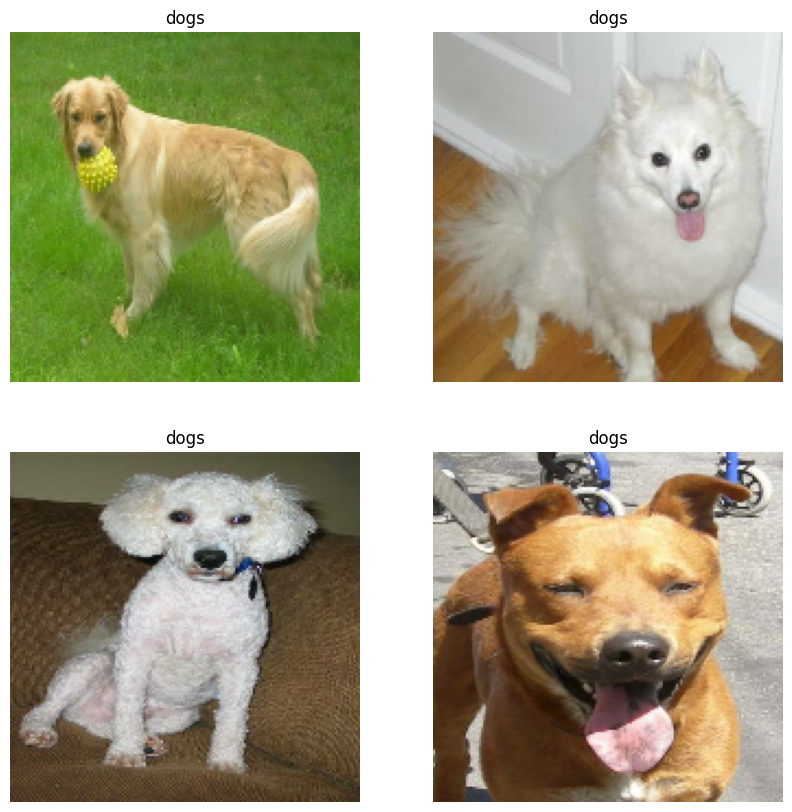

In [ ]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
  for idx in range(4):
    plt.subplot(2, 2, idx+1)
    plt.imshow(images[idx].numpy().astype('uint8'))
    plt.title(class_names[labels[idx]])
    plt.axis('off')
plt.show()

### **3. Create Model**

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

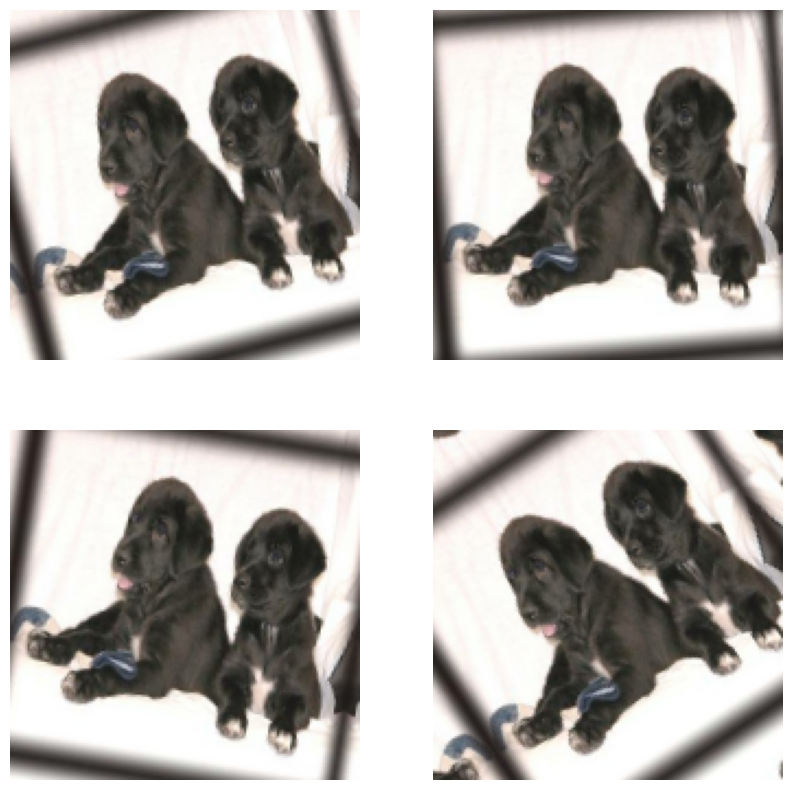

In [ ]:
plt.figure(figsize=(10, 10))

for images, _ in train_dataset.take(1):
  first_image = images[0]
  for idx in range(4):
    plt.subplot(2, 2, idx+1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0].numpy().astype('uint8'))
    plt.axis('off')

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
print('Number of trainable variables in the model is', len(model.trainable_variables))

Number of trainable variables in the model is 2


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

### **4. Train the Model**

In [ ]:
train_dataset = train_dataset.cache().shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
base_learning_rate = 0.0001

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
initial_epochs = 10

history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, verbose=1)

Epoch 1/10
63/63 [==============================] - 84s 1s/step - loss: 0.6806 - accuracy: 0.5905 - val_loss: 0.5548 - val_accuracy: 0.7376
Epoch 2/10
63/63 [==============================] - 66s 1s/step - loss: 0.5019 - accuracy: 0.7280 - val_loss: 0.3963 - val_accuracy: 0.8639
Epoch 3/10
63/63 [==============================] - 61s 971ms/step - loss: 0.4021 - accuracy: 0.8120 - val_loss: 0.3024 - val_accuracy: 0.9183
Epoch 4/10
63/63 [==============================] - 65s 1s/step - loss: 0.3418 - accuracy: 0.8540 - val_loss: 0.2413 - val_accuracy: 0.9455
Epoch 5/10
63/63 [==============================] - 65s 1s/step - loss: 0.3039 - accuracy: 0.8700 - val_loss: 0.2032 - val_accuracy: 0.9554
Epoch 6/10
63/63 [==============================] - 66s 1s/step - loss: 0.2753 - accuracy: 0.8800 - val_loss: 0.1758 - val_accuracy: 0.9604
Epoch 7/10
63/63 [==============================] - 60s 957ms/step - loss: 0.2431 - accuracy: 0.9065 - val_loss: 0.1555 - val_accuracy: 0.9616
Epoch 8/10
63/

In [ ]:
model.evaluate(validation_dataset)

26/26 [==============================] - 16s 610ms/step - loss: 0.1198 - accuracy: 0.9691


[0.11975935846567154, 0.969059407711029]

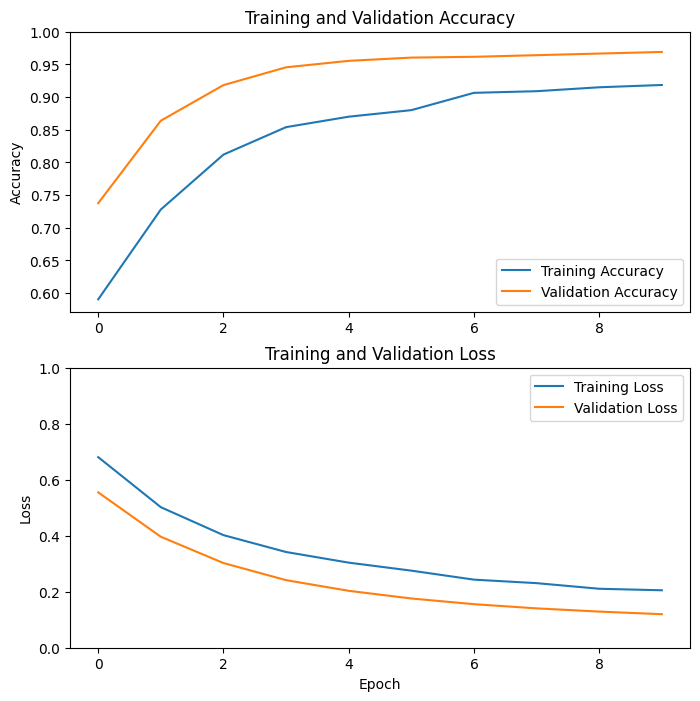

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
_ = plt.show()

### **5. Fine-tune the Model**

In [ ]:
print('Number of layers in the base model is', len(base_model.layers))

Number of layers in the base model is 154


In [ ]:
# Model will be fine-tuned from this layer onwards
fine_tune_at = 100

base_model.trainable = True

# Freezing all layers before the "fine_tune_at" layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
# Fine-tuning should be performed using a lower learning rate otherwise model could overfit very quickly
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
print('Number of trainable variables in the model is', len(model.trainable_variables))

Number of trainable variables in the model is 56


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine_tuned = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    initial_epoch=history.epoch[-1],
    epochs=total_epochs,
    verbose=1
)

Epoch 10/20
63/63 [==============================] - 96s 1s/step - loss: 0.1508 - accuracy: 0.9395 - val_loss: 0.0545 - val_accuracy: 0.9777
Epoch 11/20
63/63 [==============================] - 94s 2s/step - loss: 0.1249 - accuracy: 0.9530 - val_loss: 0.0472 - val_accuracy: 0.9827
Epoch 12/20
63/63 [==============================] - 94s 1s/step - loss: 0.1009 - accuracy: 0.9595 - val_loss: 0.0420 - val_accuracy: 0.9851
Epoch 13/20
63/63 [==============================] - 93s 1s/step - loss: 0.0886 - accuracy: 0.9615 - val_loss: 0.0394 - val_accuracy: 0.9839
Epoch 14/20
63/63 [==============================] - 93s 1s/step - loss: 0.0812 - accuracy: 0.9650 - val_loss: 0.0513 - val_accuracy: 0.9827
Epoch 15/20
63/63 [==============================] - 88s 1s/step - loss: 0.0844 - accuracy: 0.9650 - val_loss: 0.0431 - val_accuracy: 0.9814
Epoch 16/20
63/63 [==============================] - 94s 1s/step - loss: 0.0792 - accuracy: 0.9670 - val_loss: 0.0369 - val_accuracy: 0.9839
Epoch 17/20
6

In [ ]:
model.evaluate(validation_dataset)

26/26 [==============================] - 15s 581ms/step - loss: 0.0431 - accuracy: 0.9827


[0.04314031824469566, 0.9826732873916626]

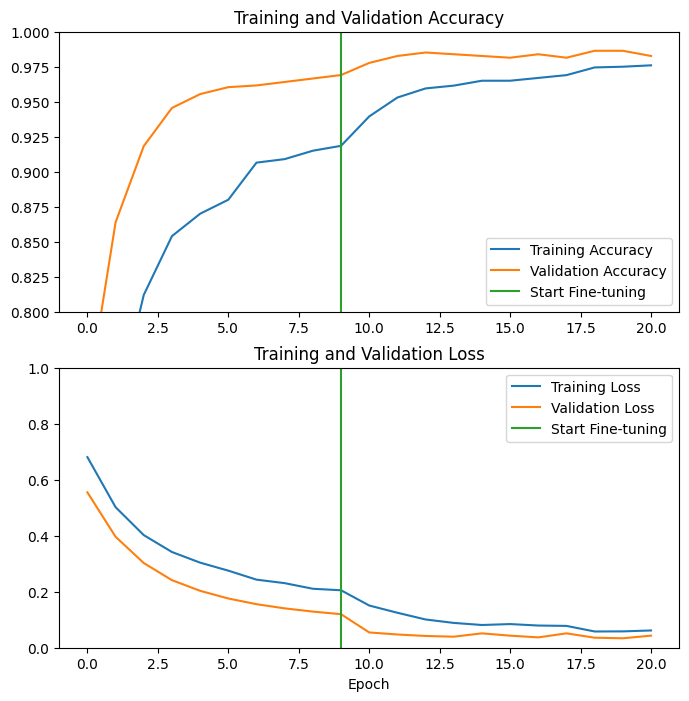

In [ ]:
accuracy += history_fine_tuned.history['accuracy']
val_accuracy += history_fine_tuned.history['val_accuracy']

loss += history_fine_tuned.history['loss']
val_loss += history_fine_tuned.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine-tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine-tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
_ = plt.show()

### **6. Predict using the Fine-tuned Model**

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print('Test accuracy:', test_accuracy)

6/6 [==============================] - 5s 847ms/step - loss: 0.0252 - accuracy: 0.9896
Test accuracy: 0.9895833134651184


Predictions:
 [1 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 1 0 1 0 0 0 0 0 1 1 0 1 1 0]
Labels:
 [1 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 1 0 1 0 0 0 0 0 1 1 0 1 1 0]


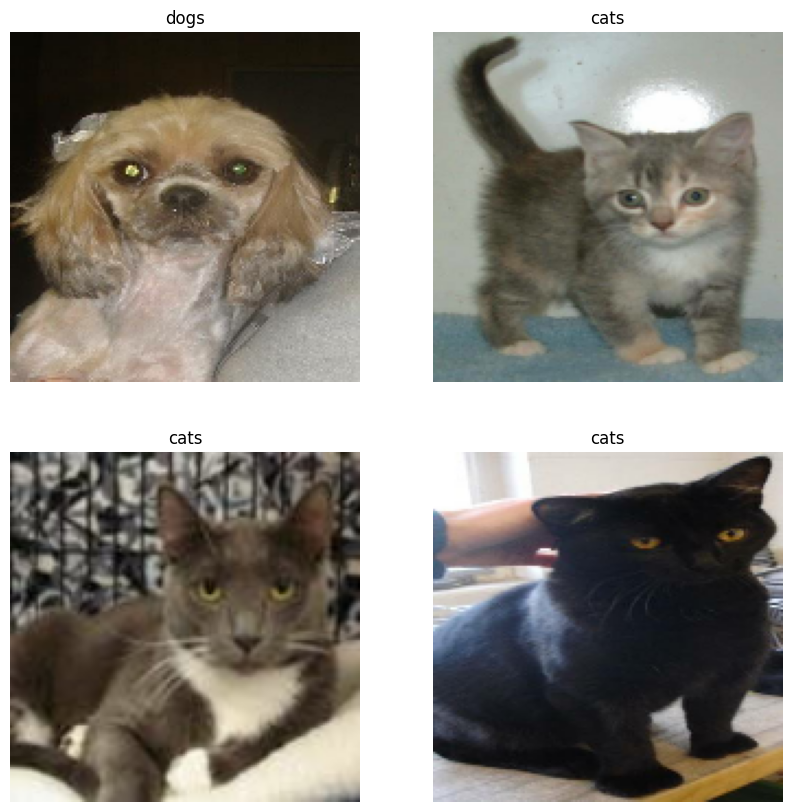

In [ ]:
# Retrieving a batch of images from test dataset
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Applying sigmoid since the model is returning logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for idx in range(4):
  plt.subplot(2, 2, idx+1)
  plt.imshow(image_batch[idx].astype('uint8'))
  plt.title(class_names[predictions[idx]])
  plt.axis('off')